In [21]:
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
import numpy as np
import floatpy.readers.padeops_reader as por
import scripts.statistics as stats
import scripts.get_namelist as nml

def visualize_one(reader, step, qname, plane, cmap, dtheta=0,domega=0,savename=''):
    reader.step = step
    fs = 12
    q = reader.readData(qname)
    q = np.squeeze(np.array(q))
    
    fig = plt.figure(figsize=(4,6), dpi=100) 
    axarr = plt.axes()

    # Plot the colors
    if plane=='xy': data2plot = np.transpose(q)
    if plane=='xz': data2plot = np.transpose(q)
    im = axarr.imshow( data2plot, cmap=cmap, origin='lower', interpolation='nearest')#spline36
    axarr.set_xticks([])
    axarr.set_yticks([]) 
    #axarr.set_ylim([Ny/2-200,Ny/2+200])
    axarr.set_title('Time: {}'.format(reader.time),size=fs)

    # set the colorbar
    divider1 = make_axes_locatable(axarr)
    cax = divider1.append_axes('right', size='5%', pad=0.1)
    maxval = np.amax(q);
    minval = np.amin(q);
    cbar = plt.colorbar(im, cax,ticks=[minval, maxval])
    cbar.ax.set_yticklabels(['%0.2f'%(minval), '%0.2f'%(maxval)]) 
    cbar.ax.tick_params(labelsize=0.75*fs)    
    
    # overlay the centerline, momentum and vorticity thickness
    if plane=='xy' and (dtheta>0 or domega>0):
        xplot = np.linspace(0,Nx-1,10)
        ones = np.ones(np.shape(xplot))
        centerline = Ny/2*ones
        lw = 0.5
        axarr.plot(xplot,centerline,'k-',alpha=0.5,linewidth=lw)
        if (domega>0):
            axarr.plot(xplot,centerline+dy*domega,'k-.',alpha=0.5,linewidth=lw)
            axarr.plot(xplot,centerline-dy*domega,'k-.',alpha=0.5,linewidth=lw)
        if (dtheta>0):
            axarr.plot(xplot,centerline+dy*dtheta,'k--',alpha=0.5,linewidth=lw)
            axarr.plot(xplot,centerline-dy*dtheta,'k--',alpha=0.5,linewidth=lw)
    
    # set the overall title and save
    if savename:
        plt.savefig(savename, dpi=500)#, bbox_inches='tight',pan_inches=0.5)
        plt.close(fig)
        print "Saved plot to ",savename
    else: plt.show
    

def which_tID(tvec,t):
    tID = np.argmin(np.abs(tvec-t))
    return tID

def growth_rates(filename_prefix):
    fname = filename_prefix+'growth.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)

    nstats=3
    dat = np.reshape(dat,[n/nstats,nstats])
    time = dat[:,0]
    dtheta = dat[:,1]
    domega = dat[:,2]
    return time,dtheta,domega    

In [29]:
# directory = "/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/512x724x256"
# directory = "/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/724x1024x362"

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/512x724x256/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1024x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1024x512/'

directory = "/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1024x512/"

# directory = "/projects/ShockInducedMix/ShearLayerData/production/Mc24/rr1/512x512x256/"

filename_prefix = directory+'/shearlayer_'
reader = por.PadeopsReader(filename_prefix, periodic_dimensions=(True,False,True))
Nx,Ny,Nz,Lx,Ly,Lz,dx,dy,dz,kx,kz = stats.domain(reader,verbose=1)
steps = sorted(reader.steps)
inp = nml.inputs(directory,verbose=True)

print("Steps: {}".format(steps))

Domain size: 100.0 x 99.90234375 x 50.0
Grid size: 1024 x 1024 x 512
Grid res: 0.09765625 x 0.09765625 x 0.09765625
Note: Missing D# multiplier for line:
	Re      = 1000           ! Reynolds number rho_Ref*dU*L/mu_ref
	Assuming multiplier is 1.

Params for this run:
	Mc = 1.2
	Re = 1000.0
	rr = 1.0
Steps: [0, 1, 2, 3, 4, 5, 6]


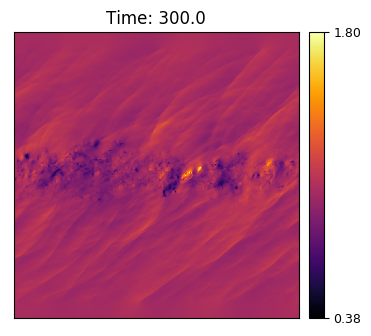

In [35]:
# plot a streamwise xy slice
zslice = Nz/2
reader.sub_domain = (0,0,zslice), (reader.domain_size[0]-1, reader.domain_size[1]-1, zslice)
step = 6
visualize_one(reader, step, qname='p',plane='xy',cmap='inferno',dtheta=0,domega=0,savename="") 
#'inferno','afmhot','viridis'

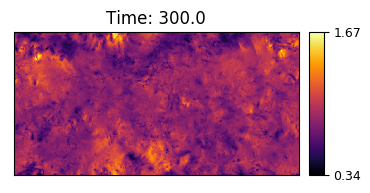

In [31]:
# plot an spanwise xz slice
yslice = Ny/2
reader.sub_domain = (0,yslice,0), (reader.domain_size[0]-1, yslice, reader.domain_size[2]-1)
step = 6
visualize_one(reader, step, qname='rho',plane='xz',cmap='inferno',savename="")

In [24]:
step = 9
time,dtheta,domega = growth_rates(filename_prefix)
print("Re = {}".format(inp.du*dtheta[step-1]/inp.mu_ref))
print("dtheta = {}".format(dtheta[step-1]))

IOError: [Errno 2] No such file or directory: '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1024x512//shearlayer_growth.dat'

In [84]:
# plot all
for step in steps[0::]:
    savename = directory+"/img/slice_xy_%04d.png"%step
    visualize_one(reader, step, qname='rho',plane='xy',cmap='afmhot',dtheta=0,domega=0,savename=savename) 

Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128//img/slice_xy_0000.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128//img/slice_xy_0001.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128//img/slice_xy_0002.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128//img/slice_xy_0003.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128//img/slice_xy_0004.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128//img/slice_xy_0005.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128//img/slice_xy_0006.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128//img/slice_xy_0007.png
Saved plot to  /projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/256x512x128//img/slice_xy_0